# Audio Based Deep Learning Models using Tensorflow (STFT-Spectograms)

## Presented by Deepthika Sivaram

## Overview

### <span style="color:#52BE80">Environmental Sound Classification with Deep Learning and STFT Spectrograms</span>



In this notebook, we'll explore how to use deep learning to classify audio signals. Our focus will be on building a model using TensorFlow that can identify different environmental sounds, like a dog barking, rain falling, or a crackling fire.

We'll achieve this by:

1.  **Transforming audio into STFT spectrograms:** Spectrograms provide a visual representation of the frequency content of an audio signal over time.
2.  **Training a Convolutional Neural Network (CNN) on these spectrograms:** CNNs are excellent at recognizing patterns in images, making them a perfect match for analyzing spectrograms.

<span style='color:#2980B9'>**Why STFT Spectrograms?**</span>

Directly using raw audio waveforms in machine learning can be difficult. STFT (Short-Time Fourier Transform) spectrograms offer a more structured and informative representation. By converting audio into spectrograms, we highlight important frequency components and create a visual representation that's easier for our CNN to learn from.

<span style='color:#2980B9'>**What is the main purpose/application?**</span>

The main goal of this project is to accurately classify environmental sounds using deep learning. This has applications in various fields, including:

*   **Smart Cities:** Monitoring urban noise for anomalies and potential issues (e.g., detecting construction noise outside permitted hours, identifying emergency vehicle sirens).
*   **Assistive Technology:** Creating devices to aid people with hearing impairments by identifying and labeling surrounding sounds (e.g., alerting to alarms, identifying speech).
*   **Environmental Monitoring:** Automatically classifying sounds in natural environments (e.g., identifying bird calls for biodiversity studies, detecting illegal logging activity).
*   **Acoustic Event Detection:** Detecting specific acoustic events in security systems.

<span style='color:#2980B9'>**Key Libraries:**</span>

*   [`librosa`](https://librosa.org/):  A powerful Python library for audio and music analysis.  We'll use it for loading audio, creating STFT spectrograms, and audio augmentations.
*   [`tensorflow`](https://www.tensorflow.org/): Google's open-source machine learning framework.  We'll use TensorFlow and Keras (its high-level API) to build, train, and evaluate our CNN.

<span style='color:#2980B9'>**Dataset:**</span>

We'll use the [ESC-50 dataset](https://github.com/karolpiczak/ESC-50), a dataset of 2000 labeled environmental audio recordings, categorized into 50 classes. You'll need to download the dataset and place the `ESC-50-master` folder in the same directory as this notebook.

*   **Structure:** The dataset contains 5-second recordings sampled at 44.1 kHz. There are 40 examples per class.
*   **Classes:** The 50 classes cover a wide range of environmental sounds, including animals (dog, cat, rooster, cow), natural sounds (rain, sea waves, crackling fire), human sounds (crying baby, sneezing, clapping), and urban sounds (siren, car horn, train).
*   **Metadata:** The `ESC-50-master/meta/esc50.csv` file contains metadata about each audio file, including:
    *   `filename`: The name of the audio file.
    *   `category`: The class label for the sound.
    *   `fold`: The cross-validation fold to which the file belongs (we'll use this for splitting our data).
    *   `esc10`: Whether the file is also part of the smaller ESC-10 dataset.
*   **Directory Structure:** After extracting the downloaded archive, you should have a directory named `ESC-50-master` with the following structure:
    ```
    ESC-50-master/
    ├── audio/
    │   ├── 1*.wav
    │   ├── 2*.wav
    │   └── ...
    └── meta/
        └── esc50.csv
    ```

**In this notebook, we will discuss about the following:**

*   **Load audio data** using the `librosa` library. (`librosa.load()`)
*   **Generate STFT spectrograms** from audio signals. (`librosa.stft()`, `librosa.amplitude_to_db()`)
*   **Construct and train a CNN** using TensorFlow/Keras.
*   **Augment audio data** to improve model performance and robustness.
*   **Evaluate trained model** to understand its capabilities.

## Installing required libraries

First we start by installing the required libraries

In [46]:
# installing required libraries
# !pip install numpy pandas matplotlib librosa tensorflow scikit-learn tqdm

## Import required libraries

In [2]:
import os                                                           # For interacting with the operating system
import numpy as np                                                  # For numerical operations
import pandas as pd                                                 # For data manipulation
import matplotlib.pyplot as plt                                     # For plotting
import librosa                                                      # For audio analysis
import librosa.display                                              # For displaying audio information such as spectrograms
import tensorflow as tf                                             # The deep learning framework
from tensorflow.keras import layers, models, regularizers           # For building neural networks
from sklearn.model_selection import train_test_split                # For splitting data
from sklearn.preprocessing import LabelEncoder                      # For encoding class labels
from tqdm import tqdm                                               # For progress bars during data processing
from sklearn.metrics import classification_report, confusion_matrix # For model evaluation
import seaborn as sns                                               # For plotting
from sklearn.preprocessing import label_binarize                    # Convert class labels to binary matric for multi-class ROC curve
from sklearn.metrics import roc_curve, auc                          # For ROC curve plotting and AUC 
from scipy.io.wavfile import write                                  # Audio file write

## Set random seed

Setting the random seed ensures that our experiments are reproducible. This means that every time we run the notebook, we'll get the same results (assuming the same code and data). This is important for debugging and comparing different models.

In [3]:
np.random.seed(42)      # Set seed for NumPy
tf.random.set_seed(42)  # Set seed for TensorFlow

## Defining Parameters

We define several paramters which govern the behavior of audio processing and deep learning model

*   `SAMPLE_RATE`:  The sample rate of the audio files (number of samples per second). 22050 Hz is a common sample rate for audio processing.
*   `DURATION`:  The duration of each audio clip in seconds. We'll be working with 5-second clips.
*   `N_FFT`:  The number of points used in the Fast Fourier Transform (FFT). This determines the frequency resolution of our spectrograms.
*   `HOP_LENGTH`:  The hop length (in samples) between successive frames in the STFT. This controls the time resolution of our spectrograms.
*   `BATCH_SIZE`: The number of samples processed in each training batch.
*   `EPOCHS`: The number of times the entire training dataset is passed through the model during training.
*   `NUM_CLASSES`: The number of classes in our dataset (50 in ESC-50).

In [5]:
SAMPLE_RATE = 22050
DURATION = 5
N_FFT = 1048
HOP_LENGTH = 512
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 50

## Load dataset

Once all the parameters are set, the first step would be to load the dataset. We first load the metadata from the `esc50.csv` file into a Pandas DataFrame. The DataFrame allows us to easily access and manipulate the dataset information (filenames, categories, folds, etc.).

In [6]:
metadata = pd.read_csv("ESC-50-master/meta/esc50.csv")

### Display metadata

In [51]:
metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


### Statistics of metadata

In [52]:
metadata.describe()

,fold,target,src_file
count,2000.000000,2000.000000,2000.000000
mean,3.000000,24.500000,137696.797500
std,1.414567,14.434479,64882.993641
min,1.000000,0.000000,137.000000
25%,2.000000,12.000000,87726.250000
50%,3.000000,24.500000,143745.500000
75%,4.000000,37.000000,188215.000000
max,5.000000,49.000000,264453.000000


## Preprocess Dataset

The next step would be to preprocess the dataset by defining functions for loading audio files, extracting STFT features, and augmenting the audio data.

### Load audio files

* We use the `librosa.load()` function to load the audio files with parameters such as file path, sample rate and duration as input.
* We make all the files to have the sample length to provide a consistent input to the model

In [7]:
def load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION):
    audio, _ = librosa.load(file_path, sr=sr, duration=duration) # Load audio file
    target_length = duration * sr # Calculate target length in samples
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant') # Pad with zeros if shorter
    else: 
        audio = audio[:target_length] # Truncate if longer
    return audio

### Extract STFT Spectrogram features

This function extracts STFT (Short-Time Fourier Transform) spectrogram features from an audio signal.

*   We use `librosa.stft()` to compute the STFT.
*   We calculate the magnitude spectrogram by taking the absolute value of the STFT result.
*   <span style='color:#2980B9'>**Why Magnitude Spectrogram?**</span>  The STFT result is complex-valued (containing both magnitude and phase information).  However, for many audio classification tasks, the *magnitude* information (the amplitude of each frequency component) is more important than the *phase* information. The magnitude spectrum represents the strength or intensity of each frequency at a given time. Discarding the phase information reduces the complexity of the data while retaining the most perceptually relevant information for tasks like sound classification.
*   We convert the magnitude spectrogram to a log scale (decibels) using `librosa.amplitude_to_db()`.  The log scale is often used because it better represents how humans perceive loudness.

In [8]:
def extract_stft_features(audio, n_fft=N_FFT, hop_length=HOP_LENGTH):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length) # Compute STFT
    mag_spectrogram = np.abs(stft)                                 # Calculate magnitude spectrogram
    log_spectrogram = librosa.amplitude_to_db(mag_spectrogram)
    if log_spectrogram.max() != log_spectrogram.min():
        log_spectrogram = (log_spectrogram - log_spectrogram.min()) / (log_spectrogram.max() - log_spectrogram.min())
    else:
        log_spectrogram = np.zeros_like(log_spectrogram)
    return log_spectrogram

### Process audio files

In [ ]:
features = []
labels = []

for index, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Processing audio files"):
    file_name = row['filename']
    category = row['category']
    file_path = os.path.join("ESC-50-master/audio", file_name)
    
    # Load and preprocess original audio
    audio = load_audio_file(file_path)
    if audio is not None:
        # Extract STFT features from original audio
        stft_features = extract_stft_features(audio)
        features.append(stft_features)
        labels.append(category)


Processing audio files: 100%|██████████| 2000/2000 [00:13<00:00, 145.78it/s]


### Visualization of spectrogram

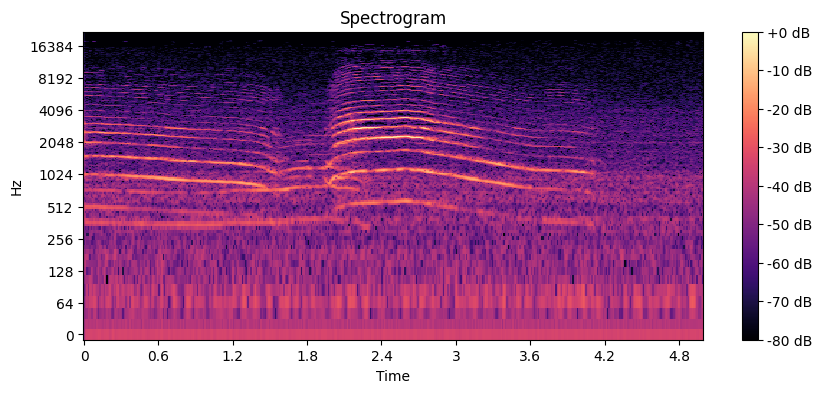

In [ ]:
sample_audio_path = "ESC-50-master/audio/1-34094-A-5.wav" # Cat sound
y, sr = librosa.load(sample_audio_path, sr=None)

plt.figure(figsize=(10, 4))
S = librosa.stft(y, n_fft=2048, hop_length=512)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
librosa.display.specshow(S_db, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()


### Convert to numpy arrays

We now convert the lists of features and labels to Numpy arrays. This is necessary for feeding the data into the TensorFlow model.

In [75]:
# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

### Add channel dimension

We then add a channel dimension to the feature array. CNNs expect input data to have a channel dimension, even if it's just 1 (for grayscale images).

In [76]:
# Add channel dimension for CNN
features = features[..., np.newaxis]

### Handle category data

We now encode the string labels (categories) into numerical labels using `LabelEncoder`. It then converts the numerical labels into one-hot encoded vectors using `tf.keras.utils.to_categorical()`. One-hot encoding is a common way to represent categorical data for training deep learning models.

In [77]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
# Convert to one-hot encoding
one_hot_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=NUM_CLASSES)

## Split data (70:15:15)

We split the data into training, validation, and test sets using `train_test_split()`.

*   We use a 70/30 split for training and temporary data and then split temporary data into validation and test data.
*   The `stratify` argument ensures that the class proportions are maintained in each split. This is important for ensuring that the model is trained on a balanced dataset.

In [78]:
X_train, X_temp, y_train, y_temp = train_test_split(
    features, one_hot_labels, test_size=0.3, random_state=42, stratify=encoded_labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [79]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (1400, 1025, 216, 1)
Testing set shape: (300, 1025, 216, 1)
Validation set shape: (300, 1025, 216, 1)


## Define the model

We now define the Convolutional Neural Network (CNN) architecture that we'll use for audio classification.

*   The `my_model` function takes the input shape and the number of classes as input.
*   It creates a `Sequential` model, which is a linear stack of layers.
*   The model consists of two convolutional blocks, each containing a `Conv2D` layer, a `BatchNormalization` layer and a `MaxPooling2D` layer with `relu` activation function.
*   The convolutional layers extract features from the spectrograms.
*   The batch normalization layers help to stabilize training.
*   The max pooling layers reduce the spatial dimensions of the feature maps.
*   The model ends with a `Flatten` layer, a `Dense` layer with 128 units, a `BatchNormalization` layer, and a `Dense` layer with the number of classes and a `softmax` activation function. Softmax is used as we are dealing with classification.
*   The final dense layer outputs the predicted probabilities for each class.

In [ ]:
def my_model(input_shape, num_classes):
    
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), padding='same', # Convolution layer with 3X3 kernel with padding 0 
                     input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'), # ReLU activation to introduce non-linearity
        layers.MaxPooling2D((2, 2)), # Max pooling with 2X2 kernel
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

Now, we define input shape to initialize the model. We calculate this from the X_train generated.

In [89]:
input_shape = X_train.shape[1:]

### Create model instance

In [90]:
model = my_model(input_shape, NUM_CLASSES)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Summary

In [91]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 1025, 216, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1025, 216, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 1025, 216, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 512, 108, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 512, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 512, 108, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 256, 54, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 884736)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │   113,246,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,272,498 (432.10 MB)

 Trainable params: 113,272,050 (432.10 MB)

 Non-trainable params: 448 (1.75 KB)

## Train the model

Before training, we need to compile the model. This involves specifying the optimizer, loss function, and evaluation metrics.

*   **Optimizer:** We use the Adam optimizer with a learning rate of 0.0001. The Adam optimizer is a popular choice for deep learning models because it adapts the learning rate for each parameter.
*   **Loss Function:** We use `categorical_crossentropy` as the loss function. This is a standard loss function for multi-class classification problems.
*   **Metrics:** We use `accuracy` as the evaluation metric.

In [92]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

This cell trains the CNN model on the training data.

*   We use `model.fit()` to train the model.
*   We pass in the training data, batch size, number of epochs, validation data, and callbacks.
*   We also specify the `verbose` argument to control the amount of output printed during training.

In [ ]:
history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=5,
        validation_data=(X_val, y_val),
        verbose=1
    )

Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.0688 - loss: 3.9222 - val_accuracy: 0.0167 - val_loss: 3.9291
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3467 - loss: 2.9094 - val_accuracy: 0.0200 - val_loss: 3.9928
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6694 - loss: 1.9535 - val_accuracy: 0.0367 - val_loss: 4.0460
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.9490 - loss: 0.8096 - val_accuracy: 0.0300 - val_loss: 4.0566
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9908 - loss: 0.3929 - val_accuracy: 0.0200 - val_loss: 4.0662


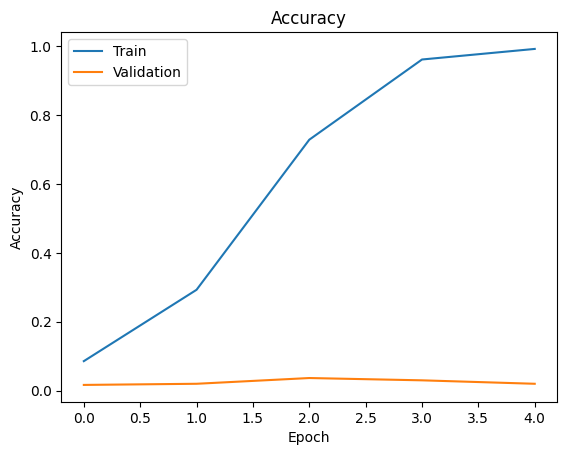

In [102]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

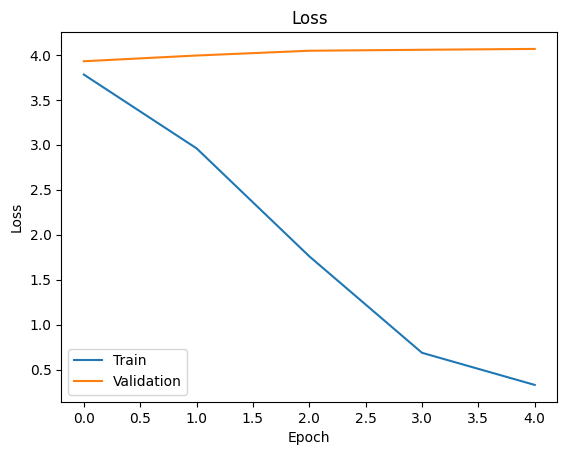

In [103]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Understanding the Training Results

From the training log:

* The model's training accuracy improves significantly from **0.0688** to **0.9908** over 5 epochs.
* However, the validation accuracy remains very low, barely exceeding **0.0367** by epoch 3 and dropping afterward.
* Meanwhile, the training loss decreases steadily, but the validation loss increases, indicating overfitting.

**Key Observations:**

* High Training Accuracy vs. Low Validation Accuracy:
* Suggests the model has memorized the training data but fails to generalize to unseen data.
* Increasing Validation Loss: Implies the model struggles to make meaningful predictions on the validation set.

**Key Issues Identified:**

* Overfitting: Model performs well on training data but poorly on validation data.
* Insufficient Generalization: Lack of exposure to diverse data representations.

**Solutions:**

* Augment Data to improve generalization.
* Include regularization techniques to prevent overfitting
* Since we will have a large amount of augmented data in hand, we must increase the complexity for our base model.


# Improving Model Performance

## Data Augmentation

### Time Shift

We perform time shifting, a data augmentation technique that shifts the audio signal in time by a random amount. This helps the model become more robust to variations in the timing of sounds.

In [110]:
def time_shift(audio, shift_range=0.2):
    t_shift = int(np.random.uniform(-shift_range, shift_range) * len(audio)) # Calculate shift
    # Pad and shift
    if t_shift > 0:
        return np.pad(audio, (0, t_shift), mode='constant')[t_shift:] 
    else:
        return np.pad(audio, (-t_shift, 0), mode='constant')[:t_shift]

### Add Noise

We add noise to the audio signal to make the model robust to noisy environment

In [111]:
def add_noise(audio, noise_factor=0.005):
    audio_noise = np.random.randn(len(audio)) # Generate random noise
    return audio + noise_factor * audio_noise # Add noise to audio

### Pitch Shift

We now shift the pitch of the audio signal up or down by a random number of semitones using `librosa.effects.pitch_shift()`

In [112]:
def pitch_shift(audio, sr=SAMPLE_RATE, steps=2):
    steps = np.random.uniform(-steps, steps) # Random number of steps for pitch shift
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=steps) # Apply pitch shift

### Time Stretch

We stretch the audio signal in time by a random factor using `librosa.effects.time_stretch()`. It ensures that the audio length remains consistent after stretching by padding or truncating as needed.

In [113]:
def time_stretch(audio, rate_range=(0.9, 1.1)):
    rnd_rate = np.random.uniform(*rate_range) # Random rate for time stretch
    stretched_audio = librosa.effects.time_stretch(audio, rate=rnd_rate) # Time stretch
    
    # Ensure the audio length is consistent after stretching
    target_length = len(audio)
    if len(stretched_audio) < target_length:
        stretched_audio = np.pad(stretched_audio, (0, target_length - len(stretched_audio)), 'constant')
    else:
        stretched_audio = stretched_audio[:target_length]
    
    return stretched_audio

### Audio Augmentation

We combine all the above discussed audio augmentation techniques to get the final augmented data for our model.

<span style='color:#2980B9'>**Why Data Augmentation?**</span>

Data augmentation is crucial for improving the performance and generalization ability of our model.

*   **Increased Data Size:** Data augmentation artificially increases the size of our training dataset by creating modified versions of the existing audio samples. And since we have only 2000 samples, we perform data augmentation to better fit our model.
*   **Robustness to Variations:** By introducing variations in time, pitch, speed, and noise, we make the model more robust to real-world conditions. For example, the model learns to recognize a "dog bark" even if it's slightly faster, slower, higher pitched, lower pitched, or recorded in a noisy environment.
*   **Prevents Overfitting:** Data augmentation helps to prevent overfitting by exposing the model to a wider range of data, forcing it to learn more generalizable features.

This helps to increase the diversity of the training data and improve the model's generalization ability.

In [114]:
def augment_audio(audio, sr=SAMPLE_RATE, augment_prob=0.7):
    augmented = audio.copy()  # Copy the audio to avoid modifying the original
    
    # Apply time shifting with a reduced probability
    if np.random.random() < augment_prob:
        augmented = time_shift(augmented)#, shift_range=0.3)
    
    # Apply pitch shifting with a reduced probability
    if np.random.random() < augment_prob:
        augmented = pitch_shift(augmented)#, sr=sr, steps=3)
    
    # Apply time stretching with a reduced probability
    if np.random.random() < augment_prob:
        augmented = time_stretch(augmented)#,rate_range=(0.8, 1.2))
    
    # Apply noise addition with a reduced probability
    if np.random.random() < augment_prob:
        augmented = add_noise(augmented)#, noise_factor=0.01)
    
    return augmented


We iterate through all the audio files listed in the metadata, load each audio file, extract STFT features, and apply data augmentation. We then store the extracted features and labels in lists.

### Process audio files

In [115]:
features = []
labels = []
augment_factor = 2

for index, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Processing audio files"):
    file_name = row['filename']
    category = row['category']
    file_path = os.path.join("ESC-50-master/audio", file_name)
    
    # Load and preprocess original audio
    audio = load_audio_file(file_path)
    if audio is not None:
        # Extract STFT features from original audio
        stft_features = extract_stft_features(audio)
        features.append(stft_features)
        labels.append(category)
        
        # Generate augmented versions
        for _ in range(augment_factor):
            augmented_audio = augment_audio(audio)
            stft_features_aug = extract_stft_features(augmented_audio)
            features.append(stft_features_aug)
            labels.append(category)


Processing audio files:  88%|████████▊ | 1764/2000 [02:30<00:20, 11.74it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
Processing audio files: 100%|██████████| 2000/2000 [02:50<00:00, 11.75it/s]


### Saving augmented audio

In [104]:
sample_audio_path = "ESC-50-master/audio/1-34094-A-5.wav" # Cat sound
y, sr = librosa.load(sample_audio_path, sr=None)

augmented_audio_dir = "augmented_audio"
os.makedirs(augmented_audio_dir, exist_ok=True)

for file in os.listdir(augmented_audio_dir):
    file_path = os.path.join(augmented_audio_dir, file)
    os.remove(file_path)


rate_range=(0.9, 1.1)
rnd_rate = np.random.uniform(*rate_range) # Random rate for time stretch
stretched_audio = librosa.effects.time_stretch(y, rate=rnd_rate) # Time stretch
# Ensure the audio length is consistent after stretching
target_length = len(y)
if len(stretched_audio) < target_length:
    stretched_audio = np.pad(stretched_audio, (0, target_length - len(stretched_audio)), 'constant')
else:
    stretched_audio = stretched_audio[:target_length]
stretched_path = os.path.join(augmented_audio_dir, "stretched.wav")
write(stretched_path, sr, (stretched_audio * 32767).astype(np.int16))
print(f"Stretched audio saved at: {stretched_path}")


steps = np.random.uniform(-2, 2) # Random number of steps for pitch shift
y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=steps) # Apply pitch shift
shifted_path = os.path.join(augmented_audio_dir, "shifted.wav")
write(shifted_path, sr, (y_shifted * 32767).astype(np.int16))
print(f"Pitch-shifted audio saved at: {shifted_path}")


audio_noise = np.random.randn(len(y)) # Generate random noise
y_noisy = y + 0.05 * audio_noise # Add noise to audio
noisy_path = os.path.join(augmented_audio_dir, "noisy.wav")
write(noisy_path, sr, (y_noisy * 32767).astype(np.int16))
print(f"Noisy audio saved at: {noisy_path}")


t_shift = int(np.random.uniform(-2, 2) * len(y)) # Calculate shift
# Pad and shift
if t_shift > 0:
    y_time = np.pad(y, (0, t_shift), mode='constant')[t_shift:] 
else:
    y_time = np.pad(y, (-t_shift, 0), mode='constant')[:t_shift]
time_path = os.path.join(augmented_audio_dir, "time_shifted.wav")
write(time_path, sr, (y_time * 32767).astype(np.int16))
print(f"Time shifted audio saved at: {time_path}")


Stretched audio saved at: augmented_audio/stretched.wav
Pitch-shifted audio saved at: augmented_audio/shifted.wav
Noisy audio saved at: augmented_audio/noisy.wav
Time shifted audio saved at: augmented_audio/time_shifted.wav


### Convert to numpy arrays

We now convert the lists of features and labels to Numpy arrays. This is necessary for feeding the data into the TensorFlow model.

In [17]:
# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

### Add channel dimension

We then add a channel dimension to the feature array. CNNs expect input data to have a channel dimension, even if it's just 1 (for grayscale images).

In [19]:
# Add channel dimension for CNN
features = features[..., np.newaxis]

### Handle category data

We now encode the string labels (categories) into numerical labels using `LabelEncoder`. It then converts the numerical labels into one-hot encoded vectors using `tf.keras.utils.to_categorical()`. One-hot encoding is a common way to represent categorical data for training deep learning models.

In [20]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
# Convert to one-hot encoding
one_hot_labels = tf.keras.utils.to_categorical(encoded_labels, num_classes=NUM_CLASSES)

## Split data (70:15:15)

We split the data into training, validation, and test sets using `train_test_split()`.

*   We use a 70/30 split for training and temporary data and then split temporary data into validation and test data.
*   The `stratify` argument ensures that the class proportions are maintained in each split. This is important for ensuring that the model is trained on a balanced dataset.

In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(
    features, one_hot_labels, test_size=0.3, random_state=42, stratify=encoded_labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [22]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (4200, 1025, 216, 1)
Testing set shape: (900, 1025, 216, 1)
Validation set shape: (900, 1025, 216, 1)


## Improve the model

We now define the Convolutional Neural Network (CNN) architecture that we'll use for audio classification.

*   The `my_model` function takes the input shape and the number of classes as input.
*   It creates a `Sequential` model, which is a linear stack of layers.
*   The model consists of four convolutional blocks, each containing a `Conv2D` layer, a `BatchNormalization` layer, a `MaxPooling2D` layer, and a `SpatialDropout2D` layer with `relu` activation function.
*   The convolutional layers extract features from the spectrograms.
*   The batch normalization layers help to stabilize training.
*   The max pooling layers reduce the spatial dimensions of the feature maps.
*   The spatial dropout layers help to prevent overfitting. Spatial dropout drops entire 2D feature maps instead of individual neurons. This is particularly effective for convolutional layers because feature maps are spatially correlated. By dropping out entire feature maps, we force the network to learn more diverse and independent features, which can improve generalization and reduce overfitting.
*   The model ends with a `Flatten` layer, a `Dense` layer with 512 units, a `BatchNormalization` layer, a `Dropout` layer, and a `Dense` layer with the number of classes and a `softmax` activation function. Softmax is used as we are dealing with classification.
*   The final dense layer outputs the predicted probabilities for each class.

In [ ]:
def my_model(input_shape, num_classes):
    # L2 regularization rate
    l2_reg = 0.0005
    
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), padding='same', # Convolution layer with 3X3 kernel with padding 0
                     kernel_regularizer=regularizers.l2(l2_reg), 
                     input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'), # ReLU activation to introduce non-linearity
        layers.MaxPooling2D((2, 2)), # Max pooling with 2X2 kernel
        layers.SpatialDropout2D(0.3), # Dropout to prevent overfitting by randomly disabling neurons
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.3),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.4),
        
        #Fourth convolutional block
        layers.Conv2D(256, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.4),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, 
                    kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

Now, we define input shape to initialize the model. We calculate this from the X_train generated.

In [24]:
input_shape = X_train.shape[1:]

### Create model instance

In [25]:
model = my_model(input_shape, NUM_CLASSES)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-02 22:41:58.774098: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-03-02 22:41:58.779027: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-02 22:41:58.779041: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-02 22:41:58.779086: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-02 22:41:58.779108: I tensorflow/core/common_runtime/pluggable_device/pl

### Model Summary

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1025, 216, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1025, 216, 32)  │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1025, 216, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 512, 108, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 512, 108, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 512, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512, 108, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 256, 54, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 256, 54, 64)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 54, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 54, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256, 54, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 27, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 128, 27, 128)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 27, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 27, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 27, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 64, 13, 256)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 212992)         │             

 Total params: 109,469,874 (417.59 MB)

 Trainable params: 109,467,890 (417.59 MB)

 Non-trainable params: 1,984 (7.75 KB)

## Train the model

Before training, we need to compile the model. This involves specifying the optimizer, loss function, and evaluation metrics.

*   **Optimizer:** We use the Adam optimizer with a learning rate of 0.0003. The Adam optimizer is a popular choice for deep learning models because it adapts the learning rate for each parameter.
*   **Loss Function:** We use `categorical_crossentropy` as the loss function. This is a standard loss function for multi-class classification problems.
*   **Metrics:** We use `accuracy` as the evaluation metric.

In [106]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

### Define callbacks

Callbacks are used to monitor the training process and automatically adjust the model's behavior.

*   **`EarlyStopping`:** This callback stops training when the validation loss stops improving for a specified number of epochs (`patience=5`). It also restores the best model weights.
*   **`ReduceLROnPlateau`:** This callback reduces the learning rate when the validation loss stops improving for a specified number of epochs (`patience=3`). This can help the model to converge to a better solution.
*   **`ModelCheckpoint`:** Saves the model with the best validation accuracy.
*   **`LearningRateScheduler`:**  Dynamically adjusts the learning rate after each epoch based on a schedule. We have set for the learning rate to decay by 5% every epoch. This helps the model train faster initially and refine weights gradually in later stages, improving convergence.


In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.95 ** epoch)

callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=2
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'animal_class_model.keras', save_best_only=True, monitor='val_accuracy'
        ),
        lr_scheduler
    ]

This cell trains the CNN model on the training data.

*   We use `model.fit()` to train the model.
*   We pass in the training data, batch size, number of epochs, validation data, and callbacks.
*   We also specify the `verbose` argument to control the amount of output printed during training.

In [33]:
history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - accuracy: 0.0844 - loss: 7.8290 - val_accuracy: 0.0278 - val_loss: 6.5905 - learning_rate: 0.0010
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.1637 - loss: 5.6129 - val_accuracy: 0.0200 - val_loss: 6.0081 - learning_rate: 9.5000e-04
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.2191 - loss: 4.9197 - val_accuracy: 0.2289 - val_loss: 4.8336 - learning_rate: 9.0250e-04
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.2786 - loss: 4.6513 - val_accuracy: 0.3767 - val_loss: 4.3382 - learning_rate: 8.5737e-04
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.3200 - loss: 4.4691 - val_accuracy: 0.4011 - val_loss: 4.1636 - learning_rate: 8.1451e-04
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.3746 - loss: 4.2686 - val_accuracy: 0.4456 - val_loss: 4.0441 - learning_rate: 7.7378e-04
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accurac

### Training Summary
- **Total Epochs:** 50  
- **Initial Learning Rate:** 0.001, decayed by 5% each epoch.  
- **Final Learning Rate:** ~8.1e-05.  

### Performance Overview
- **Training Accuracy:** Improved from **0.0844** to **0.9914**, indicating effective learning.  
- **Validation Accuracy:** Increased from **0.0278** to **0.7100**, suggesting decent generalization.  
- **Training Loss:** Decreased from **7.8290** to **0.6379**, showing efficient error minimization.  
- **Validation Loss:** Reduced from **6.5905** to **1.6225**, but fluctuated slightly, indicating potential overfitting.  

### Key Observations
- **Early Overfitting:** The gap between training and validation accuracy suggests slight overfitting.  
- **Learning Rate Scheduler:** Gradual decay helped stabilize training and improved convergence.  
- **Overall:** Achieved high training accuracy with moderate validation performance.  


## Evaluate the Model

Once training is complete, it's important to evaluate the model.

In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 312ms/step - accuracy: 0.7198 - loss: 1.5912
Test accuracy: 0.7311


- **Test Accuracy:** **0.7311**  
   - Indicates that the model correctly classified **73.11%** of the test samples.  
   - Suggests decent generalization ability on unseen data.

- **Test Loss:** **1.5912**  
   - Measures the error in predictions on the test set.  
   - A relatively moderate loss indicates that the model has learned meaningful patterns but might still have room for improvement.

### Key Insights
- **Consistency:** Test accuracy (**0.7311**) is close to validation accuracy (**0.7100**), suggesting that the model does not overfit excessively.  
- **Potential Improvements:** Fine-tuning hyperparameters, adjusting dropout rates, or enhancing feature extraction could further reduce loss and improve accuracy.  
- **Overall:** The model demonstrates a balanced performance, indicating effective learning and decent generalization to new data.  


## Evaluation Plots

We generate plots of the training and validation accuracy and loss over the epochs. These plots help us visualize the training process and identify potential issues like overfitting.

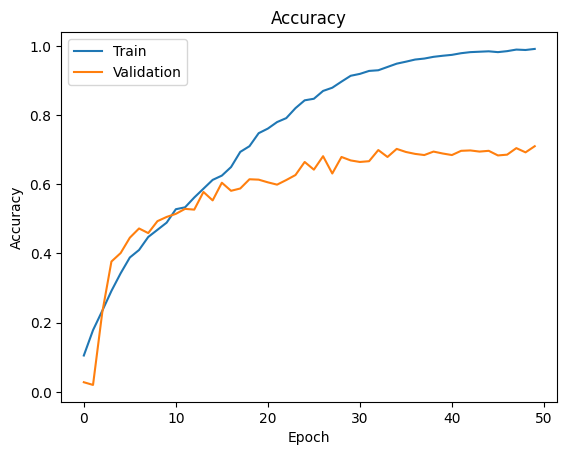

In [35]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

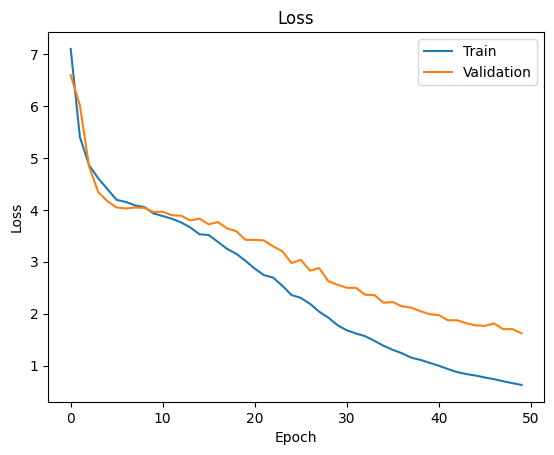

In [ ]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Interpretation of Training and Loss Graphs

**Accuracy Plot:**
* Training Accuracy (Blue): Increases steadily, indicating that the model is learning effectively.
* Validation Accuracy (Orange): Peaks early and fluctuates, suggesting possible overfitting after a certain point.

**Loss Plot:**
* Training Loss (Blue): Consistently decreases, showing that the model minimizes the error during training.
* Validation Loss (Orange): Reduces initially but then shows slower improvement and slight fluctuations, indicating that generalization might need enhancement.

#### Key Insights

* Overfitting: The widening gap between training and validation accuracy suggests overfitting. Better feature extraction can help with overfitting.
* Learning Rate: The steady decrease in training loss indicates a suitable learning rate, but validation fluctuations suggest possible fine-tuning.
* Addressing overfitting might improve validation performance and stabilize accuracy.


In [37]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step


In [38]:
print("\nClassification Report:")
class_report = classification_report(
    true_classes, 
    predicted_classes, 
    target_names=label_encoder.classes_
)
print(class_report)


Classification Report:
                  precision    recall  f1-score   support

        airplane       0.78      0.78      0.78        18
       breathing       0.85      0.61      0.71        18
  brushing_teeth       0.69      0.50      0.58        18
     can_opening       0.65      0.72      0.68        18
        car_horn       0.81      0.72      0.76        18
             cat       0.69      0.61      0.65        18
        chainsaw       0.76      0.72      0.74        18
  chirping_birds       0.85      0.94      0.89        18
    church_bells       0.85      0.94      0.89        18
        clapping       0.68      0.94      0.79        18
     clock_alarm       0.54      0.83      0.65        18
      clock_tick       0.86      0.67      0.75        18
        coughing       0.78      0.78      0.78        18
             cow       0.89      0.89      0.89        18
  crackling_fire       0.65      0.72      0.68        18
        crickets       0.91      0.56      0.69

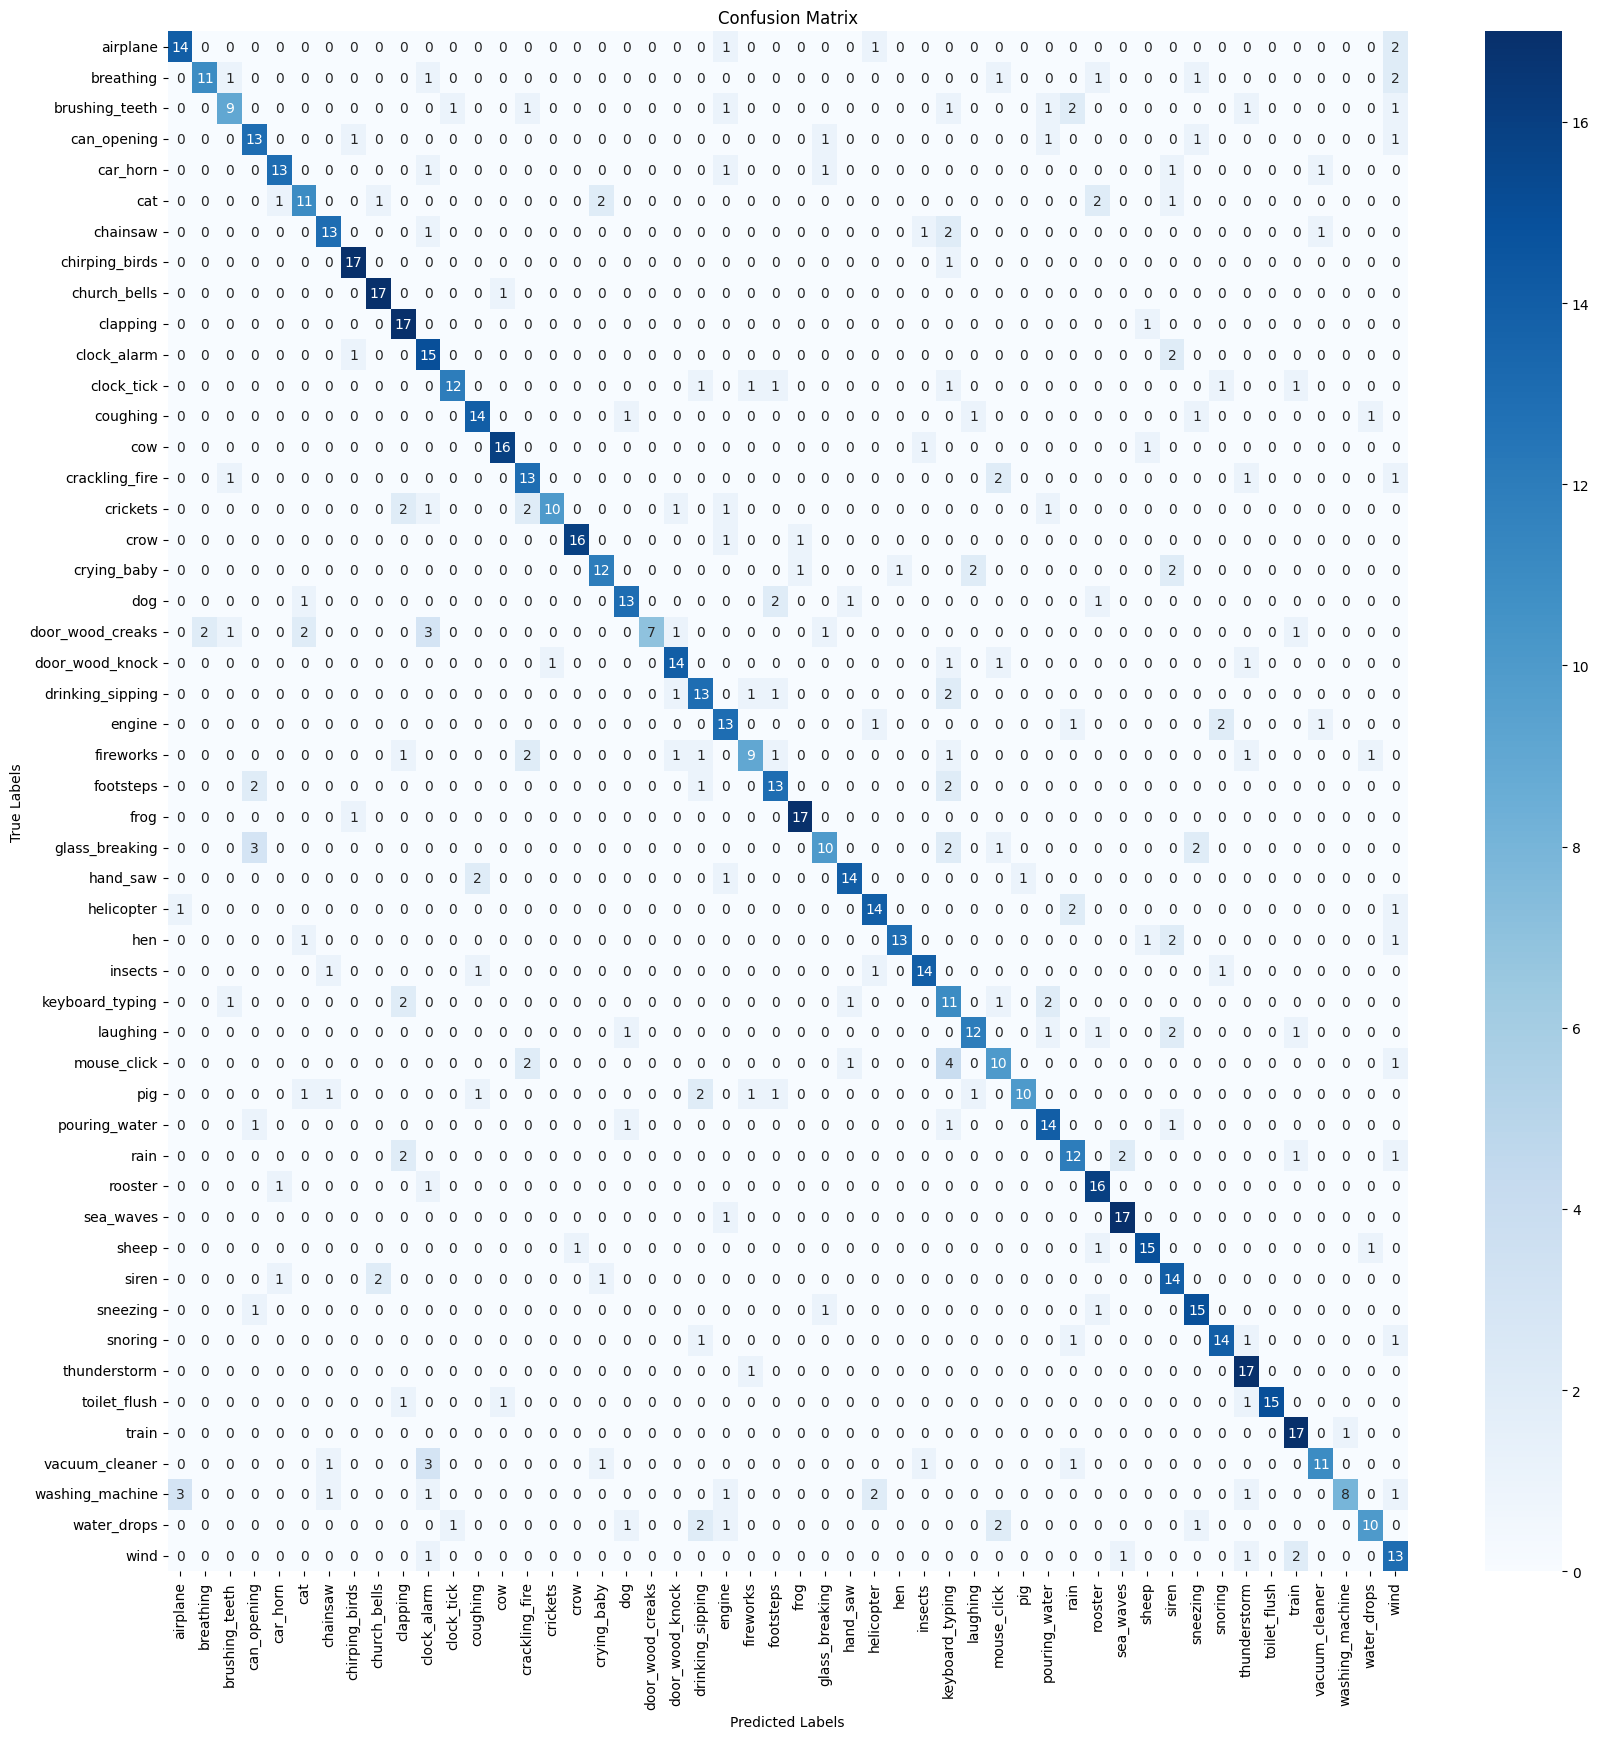

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### Confusion Matrix
* Diagonal Dominance: Most predictions fall along the diagonal, indicating that the model correctly classifies a majority of the samples.
* Misclassifications: Some off-diagonal values suggest that the model confuses certain classes, possibly due to similar acoustic features.

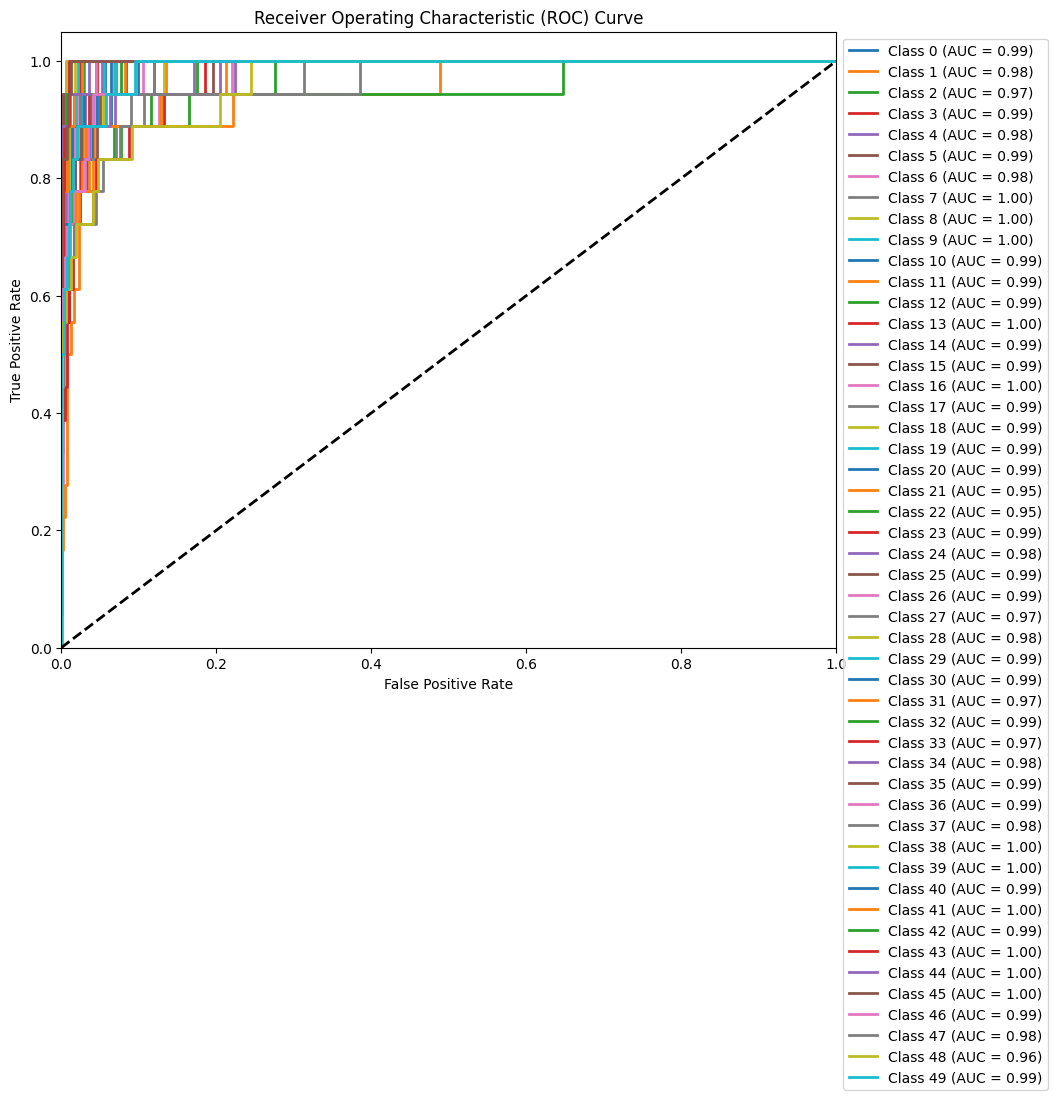

In [ ]:
n_classes = predictions.shape[1]  # number of classes
true_classes_bin = label_binarize(true_classes, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot each class's ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot a diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set the plot details
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="upper left",bbox_to_anchor=(1,1))
plt.show()


### ROC Curve Explanation

* AUC Values: Most classes have AUC values close to 1.0, indicating high discriminative ability.
* Consistency: Uniform AUC scores across classes suggest balanced model performance.
* Improvement Areas: Classes with lower AUC scores could benefit from feature engineering or enhanced data representation.

# Save Weights

We save the weights of the model

In [41]:
model.save('animal_class_model.keras')
print("Model saved successfully!")

Model saved successfully!


# Testing on a random audio file

Load the model weights from the saved model

In [ ]:
# Load model weights
model = tf.keras.models.load_model('animal_class_model.keras')

Load the audio and extract the STFT features. We might also need to reshape the features to match the model input

In [ ]:
wav_file_path = 'mixkit-cartoon-kitty-begging-meow-92.wav' # Cat sound

# Load audio and extract STFT features
audio = load_audio_file(wav_file_path)
stft_features = extract_stft_features(audio)

# Reshape to match model input (add channel dimension)
stft_features = np.expand_dims(stft_features, axis=-1)
stft_features = np.expand_dims(stft_features, axis=0)

We now make predictions using the `model.predict()` function. The predicted class is not converted back to labels to print the output.

In [ ]:
# Make a prediction
prediction = model.predict(stft_features)
predicted_class = np.argmax(prediction, axis=1)[0]

# Convert back to categorical
metadata = pd.read_csv("ESC-50-master/meta/esc50.csv")
label_encoder = LabelEncoder()
label_encoder.fit(metadata['category'])

predicted_label = label_encoder.inverse_transform([predicted_class])[0]
print(f"Predicted Class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: cat


The model successfully predicted the sound category as "cat", which is the correct label for the input audio. This result demonstrates the effectiveness of using STFT features combined with a Convolutional Neural Network for environmental sound classification.

# Short Task for the Audience
To practice the skills learned, try modifying the feature extraction code to use **Mel-spectrograms** instead of standard STFT features.


**Task:**
1. Update the `extract_stft_features` function to convert STFT to **Mel-spectrograms** as shown in the code snippet:
   - Use `librosa.feature.melspectrogram` to extract Mel-scale features.
   - Apply log scaling using `librosa.power_to_db`.
   - Normalize the features to a range of [0, 1].
2. Adjust the input shape for the model based on the Mel-spectrogram dimensions.
3. Retrain the model using the new features and plot the accuracy and loss curves.
4. Compare the performance with the original STFT-based model.


Observe if the Mel-spectrogram improves validation accuracy and reduces overfitting.


This task will help understanding how Mel-scale conversion affects feature representation and model performance.


### What is a Mel-Spectrogram?
A **Mel-spectrogram** is a type of spectrogram that shows how sound frequencies change over time, using the **Mel scale** to mimic how humans hear.


#### Why Convert to Mel-Spectrogram?
1. **Matches Human Hearing:**  
   - Focuses more on lower frequencies, which humans hear better.

2. **Simplifies Features:**  
   - Reduces the complexity of the data, making it easier for models to learn patterns.

3. **Improves Accuracy:**  
   - Helps neural networks focus on important parts of the audio, boosting performance.

Mel-spectrograms make it easier for models to understand audio by focusing on the frequencies that matter most to humans.  


In [ ]:
def extract_stft_features(audio, n_fft=N_FFT, hop_length=HOP_LENGTH):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    mag_spectrogram = np.abs(stft)
    
    # Convert magnitude specrogram to mel scale
    mel_spectrogram = librosa.feature.melspectrogram(
        S=mag_spectrogram**2, 
        sr=SAMPLE_RATE,
        n_mels=128
    )
    
    # Convert to log scale
    log_spectrogram = librosa.power_to_db(mel_spectrogram)
    
    # Normalize to range [0, 1]
    if log_spectrogram.max() != log_spectrogram.min():
        log_spectrogram = (log_spectrogram - log_spectrogram.min()) / (log_spectrogram.max() - log_spectrogram.min())
    else:
        log_spectrogram = np.zeros_like(log_spectrogram)
        
    return log_spectrogram

# References

1. Librosa - https://librosa.org/doc/main/generated/librosa.stft.html
2. Numpy - https://numpy.org/doc/
3. Matplotlib - https://matplotlib.org/stable/api/pyplot_summary.html
4. Seaborn - https://seaborn.pydata.org/tutorial.html
5. sklearn - https://scikit-learn.org/stable/
6. Tensorflow - https://www.tensorflow.org/guide
7. Pandas - https://pandas.pydata.org/docs/
8. Dataset - ESC50 - https://github.com/karolpiczak/ESC-50
9. TQDM - https://tqdm.github.io/
10. Data Augmentation - https://www.kaggle.com/code/huseinzol05/sound-augmentation-librosa
11. Random Audio - https://mixkit.co/free-sound-effects/cat/